# Detecting Outliers with Cleanlab and PyTorch Image Models (timm)

This 5-minute tutorial show how to detect potential outliers in image data using Cleanlab and PyTorch. The dataset used is `cifar10` which contains 60,000 images. Each image belongs to 1 of 10 classes: `[airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]`. 

**Overview of what we'll do in this tutorial:**

- Load the [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset and do some basic data pre-processing.
- Create `train_data` and `test_data` such that `train_data` only contains animals and `test_data` contains all classes.
- Load pretrained `timm` model and extract `train_data` and `test_data` feature embeddings.
- Use `cleanlab` to find naturally occuring outlier examples in the `train_data`.
- Use `cleanlab` to find outlier examples (non-animals) in the `test_data`.
- Explore threshold selection for labeling outliers

<div class="alert alert-info">
Quickstart
<br/>
    
Do you already have `feature_embeddings` from your data? Run the code below to generate outlier scores.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from sklearn.neighbors import NearestNeighbors
from cleanlab.rank import get_outlier_scores

# To get outlier scores for train_data using train_feature_embeddings
outlier_scores = get_outlier_scores(features=train_feature_embeddings)

# To get outlier scores for test_data using feature matrix test_feature_embeddings
knn = NearestNeighbors(n_neighbors=10, metric="cosine").fit(train_feature_embeddings)
outlier_scores = get_outlier_scores(features=test_feature_embeddings, knn=knn)
    

```
    
</div>
</div>

<div class="alert alert-info">
<h2 class="alert-heading">Quickstart</h2>
<br/>
    
Do you already have `feature_embeddings` from your data? Run the code below to generate outlier scores.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from sklearn.neighbors import NearestNeighbors
from cleanlab.rank import get_outlier_scores

# To get outlier scores for train_data using train_feature_embeddings
outlier_scores = get_outlier_scores(features=train_feature_embeddings)

# To get outlier scores for test_data using feature matrix test_feature_embeddings
knn = NearestNeighbors(n_neighbors=10, metric="cosine").fit(train_feature_embeddings)
outlier_scores = get_outlier_scores(features=test_feature_embeddings, knn=knn)
    

```
    
</div>
</div>

## 1. Install the required dependencies
You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install cleanlab
...
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)
# Package versions we used: matplotlib==3.5.1, numpy==1.21.6, torch==1.11.0, scikit-learn==1.0.2, torchvision==0.12.0, timm==0.5.4, cleanlab==2.0.0

dependencies = ["matplotlib", "torch", "torchvision", "sklearn", "timm"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

Lets first import the required packages and set some seeds for reproducibility

In [2]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import warnings

import cleanlab
from cleanlab.rank import get_outlier_scores
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import NearestNeighbors # import KNN estimator
from sklearn.model_selection import train_test_split

import timm # resnet50 pre-trained model

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## 2. Fetch and scale the Cifar10 dataset

Import `cifar10` dataset. After some basic preprocessing, we manually remove some classes from the training examples thereby making them outliers in the test set. For this example we've chosen to remove all classes that are not an animal `[airplane, automobile, ship, truck]` from the training set `trainX`.

In [3]:
# Select how to load the cifar10 datasets. Load into tensors for training.
transform_normalize = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),])

# Load cifar10 datasets
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_normalize)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_normalize)

# Manually remove non-animals out of the training dataset
animal_labels = [2,3,4,5,6,7]
animal_idxs = np.where(np.isin(train_data.targets, animal_labels))[0]

# Select small subset of train/test data
train_idxs = np.random.choice(animal_idxs, len(animal_idxs) // 4, replace=False)
test_idxs = np.random.choice(range(len(test_data)), len(test_data) // 4, replace=False)

train_data  = torch.utils.data.Subset(train_data, train_idxs) # Select subset of animals for our train_data
test_data  = torch.utils.data.Subset(test_data, test_idxs) # Select subset of animals for our train_data

# Check the shapes of our training and test sets
print('train_data length: %s' % (len(train_data)))
print('test_data length: %s' % (len(test_data)))

Files already downloaded and verified
Files already downloaded and verified
train_data length: 7500
test_data length: 2500


#### Lets visualize some of the training and test examples

In [4]:
txt_labels = {0: 'airplane', 
              1: 'automobile', 
              2: 'bird',
              3: 'cat', 
              4: 'deer', 
              5: 'dog', 
              6: 'frog', 
              7: 'horse', 
              8:'ship', 
              9:'truck'}

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_images(dataset):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        X,y = dataset[i]
        ax = plt.subplot(3,5,i+1)
        ax.set_title(txt_labels[int(y)])
        ax.imshow(imshow(X))
    plt.show()

Observe how there are only animals left in the training set `train_data` below.

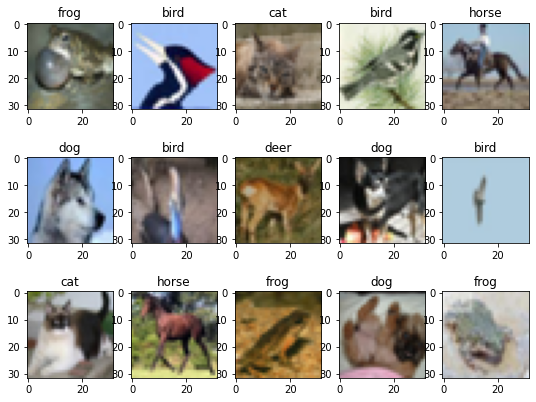

In [5]:
plot_images(train_data)

The test set on the other hand still visibily contains the non-animal images: `[ship, airplane, automobile, truck]`. If we consider `train_data` to be the representative of the normal data distribution then these non-animal images in `test_data` become outliers.

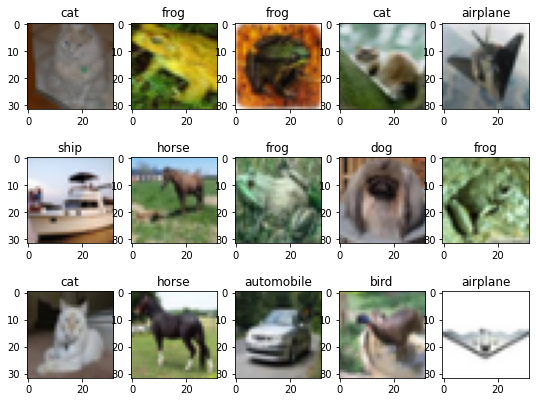

In [6]:
plot_images(test_data)

## 3. Import a model and get embeddings
We pass in the images into the model to generate embeddings in the feature space that we require as inputs for the outlier detection algorithm. 

The model we are importing is a `resnet50` that comes from [timm](https://timm.fast.ai/), a deep-learning library collection of SOTA models and utilities but outlier detection can be done with any method capable of generating feature embeddings.

In [7]:
# Helper function for using a model to generate feature embedding from image data
def embed_images(model, dataloader):
    feature_embeddings = []

    for data in dataloader:
        images, labels = data
        with torch.no_grad():
            embeddings = model(images)
            feature_embeddings.extend(embeddings.numpy())
    feature_embeddings = np.array(feature_embeddings)
    return feature_embeddings

In [8]:
# Download the model from timm and set to eval mode
model = timm.create_model('resnet50', pretrained=True, num_classes=0)
model.eval()

# Create dataloaders for more efficient data streaming to the model
batch_size = 50
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Generate feature embeddings of the training data using the model
train_feature_embeddings = embed_images(model, trainloader) # This can take several mins
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')

# Generate feature embeddings of the test data using the model
test_feature_embeddings = embed_images(model, testloader) # This can take several mins
print(f'Test embeddings pooled shape: {test_feature_embeddings.shape}')

Train embeddings pooled shape: (7500, 2048)
Test embeddings pooled shape: (2500, 2048)


## 4. Use cleanlab to find outliers in the dataset
With just the feature embeddings and ``cleanlab`` we can now identify outliers in the data. 

### Finding naturally occuring outlier examples in the train_data

Calling ``get_outlier_score()`` on ``train_feature_embeddings`` will find any naturally occuring outliers in ``train_data``. These examples should be animal images that look strange or different from the majority of other animal images in the data.

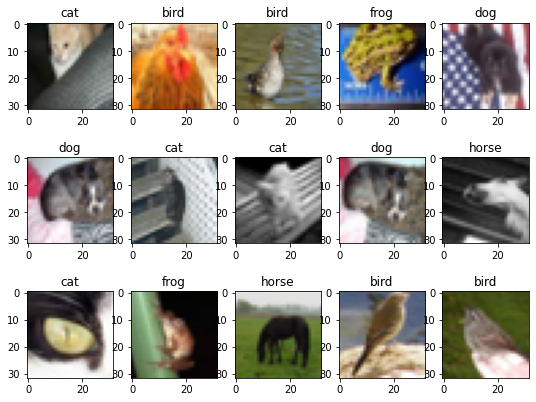

In [9]:
# Get outlier scores for our train feature embeddings
train_outlier_scores = get_outlier_scores(features=train_feature_embeddings)

# Visualize top 15 most likeley outlier scores
top_train_outlier_idxs = (train_outlier_scores).argsort()[:15]
top_train_outlier_subset = torch.utils.data.Subset(train_data, top_train_outlier_idxs)
plot_images(top_train_outlier_subset)

Just for fun, lets see what our model considers the least likeley outliers in the training set! These examples look very homogeneous as they are very close together in the feature space to many of their neighbors. Two of the deer images are almost mirror versions of each other.

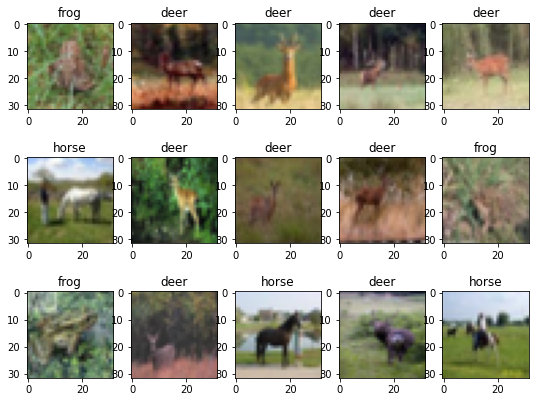

In [10]:
# Visualize 15 least probable outlier scores on train_data
bottom_train_outlier_idxs = (-train_outlier_scores).argsort()[:15]
bottom_train_outlier_subset = torch.utils.data.Subset(train_data, bottom_train_outlier_idxs)
plot_images(bottom_train_outlier_subset)

### Finding outlier examples in the test_data
We can also use ``get_outlier_score()`` to find the artificially added outlier classes `[airplanes, automobiles, trucks, boats]` into the test dataset.

We will begin with creating an ``sklearn.neighbors.NearestNeighbor`` estimator to fit on the ``train_feature_embeddings`` (i.e. the train dataset). The function can be called without passing in a ``knn`` object in which case one will be created internally.

In [11]:
# Import KNN estimator and fit it on the train feature embeddings
knn = NearestNeighbors(n_neighbors=20,metric="cosine").fit(train_feature_embeddings)

# Get outlier scores for the test feature embeddings
test_outlier_scores = get_outlier_scores(features=test_feature_embeddings, knn=knn)

<div class="alert alert-info">
Not sure which distance metric to use?
<br/>
    
By default `sklearn.neighbors.NearestNeighbor` uses` minkowski` distance, but we generally recommend using `cosine` distance instead when computing distances between neural net representations of data. Internally, `get_outlier_score()` uses sklearn's KNN based on `cosine` distance already.
</div>

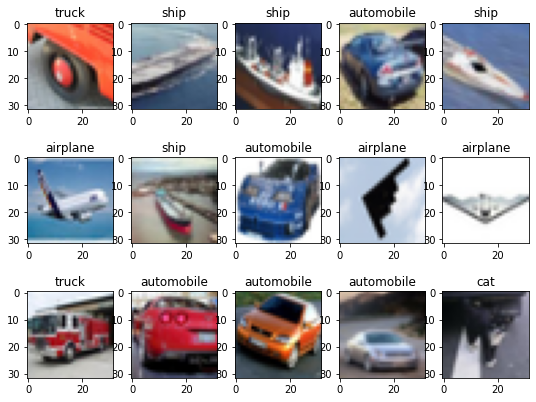

In [12]:
# Visualize top 15 most likeley outlier scores
top_outlier_idxs = (test_outlier_scores).argsort()[:15]
top_outlier_subset = torch.utils.data.Subset(test_data, top_outlier_idxs)
plot_images(top_outlier_subset)

Notice how almost all outliers identified in `test_data` belong to the holdout classes `[airplane, automobile, ship]`. These feature representations are futher away in the feature space than the feature representations of animal images also found in `test_data`.

Just for fun, lets visualize what the `NearestNeighbors` algorithm considers the 15 least probable outliers in our test set.

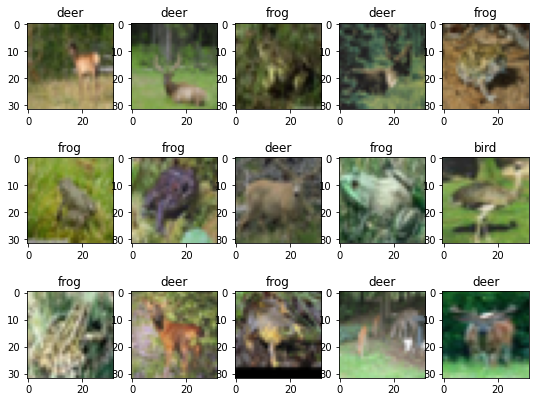

In [13]:
# Visualize 15 least likeley to be outlier scores
bottom_outlier_idxs = (-test_outlier_scores).argsort()[:15]
bottom_outlier_subset = torch.utils.data.Subset(test_data, bottom_outlier_idxs)
plot_images(bottom_outlier_subset)

Notice there are no images from the out of distribution classes here and all the animals are visually similar to each other.

We can also compute the precision/recall curve of our algorithm for the examples.

In [14]:
animal_labels = [2,3,4,5,6,7] # Animal labels to identify in the dataset
test_data_labels = np.array(test_data.dataset.targets) # Get subset labels from out test_data
animal_idxs = np.where(np.isin(test_data_labels[test_data.indices], animal_labels))[0] # Find animal idxs
not_outlier = np.zeros(len(test_data), dtype=bool)
not_outlier[animal_idxs] = True
precision, recall, thresholds = precision_recall_curve(not_outlier, 1 - test_outlier_scores)

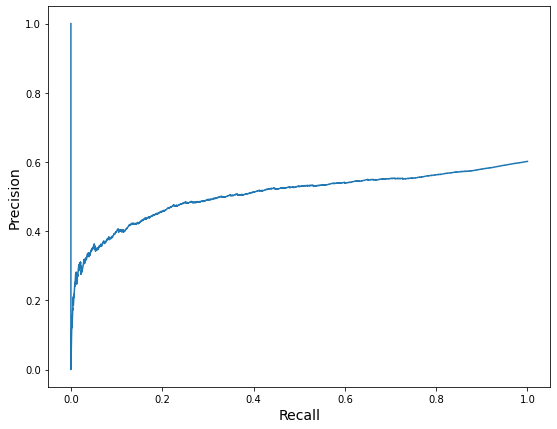

In [15]:
plt.plot(recall, precision)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.show()

## 4. Thresholding outliers in outlier_scores

Now that we know how to find the outlier scores, how do we determine how many of the lowest ranked indices in ``test_data`` should be marked as outliers? We can use the `train_outlier_scores` distribution to calcualte a threshold for the `test_data`.

If we want to select a hard threshold for outlier detection on the future test data that gives us around 5% false positives. We can look at the distribution of outlier_scores for the `train_data` (assuming it has no outliers) and use the 5-th percentile of this distribution as the threshold below which to call a test example an outlier.

Lets first take a look at our score distributions and see where the 5th precentile falls (along red line).

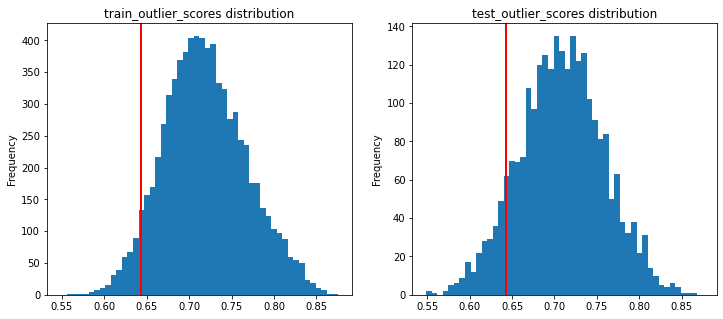

In [16]:
# Calculate 5th percentile of the train_data distribution
fifth_percentile = np.percentile(train_outlier_scores, 5)

# Plot outlier_score distributions and the 5th percentile cutoff
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt_range = [min(train_outlier_scores.min(),test_outlier_scores.min()), \
             max(train_outlier_scores.max(),test_outlier_scores.max())]
axes[0].hist(train_outlier_scores, range=plt_range, bins=50)
axes[0].set(title='train_outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=fifth_percentile, color='red', linewidth=2)
axes[1].hist(test_outlier_scores, range=plt_range, bins=50)
axes[1].set(title='test_outlier_scores distribution', ylabel='Frequency')
axes[1].axvline(x=fifth_percentile, color='red', linewidth=2)

plt.show()

Everything to the left of the red line in the distribution of `test_outlier_scores` will be marked as an outlier. Let's measure how well this works. 

**Visually check the threshold**

First lets plot the least sure outliers of our `test_data`. These are the images immediately to the left of that cuttoff line. As you can see majority of them are still true outliers however there are a few less standard looking animals that are now falseley identified as outliers as well.

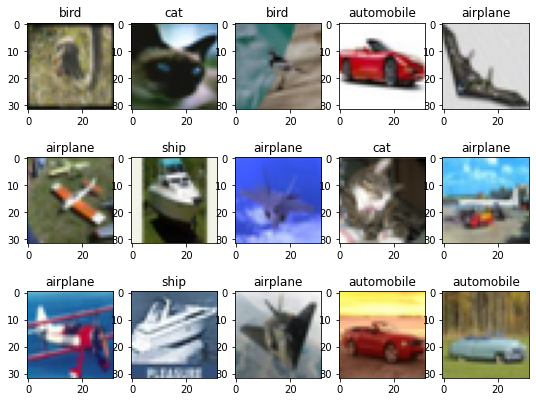

In [17]:
# Visualize 15 outlier scores right along the cuttoff (i.e. the least likeley outliers given threshold)
sorted_idxs = test_outlier_scores.argsort()
outlier_scores = test_outlier_scores[sorted_idxs]
outlier_indices = sorted_idxs[outlier_scores < fifth_percentile] # Images in test data flagged as outliers

selected_outlier_subset = torch.utils.data.Subset(test_data, outlier_indices[::-1])
plot_images(selected_outlier_subset)

**Empirically measure threshold effectiveness**

Setting the hard threshold to the 5-th percentile of the `train_data` gives us almost exactly a 5% false positive rate. If that is what we are looking for, this is an effective threshold cuttoff for this data distribution.

In [18]:
animal_labels = [2,3,4,5,6,7] # Animal labels in the dataset
test_data_labels = np.array(test_data.dataset.targets) # Get subset labels from out test_data
animal_idxs = np.where(np.isin(test_data_labels[test_data.indices], animal_labels))[0]

false_positive_idxs = set(outlier_indices).intersection(set(animal_idxs))
FPR = len(false_positive_idxs) / (len(false_positive_idxs) + len(animal_idxs))
print(f'Number of false positives detected: {len(false_positive_idxs)}\nFalse positive rate: {round(FPR,4)} ')

Number of false positives detected: 84
False positive rate: 0.0529 


In [19]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

top_outlier_idxs_test = [ 311,  776, 1997, 1357,  149, 2130, 1737, 1696,  504,   14, 1761, 908, 1621, 1405, 1798]
top_outlier_idxs_train = [3189, 4118, 5012, 2525, 3555, 1419, 4604, 2514, 6663, 1892, 1317, 4737, 4612, 7062, 5960]

if not all(x in top_outlier_idxs for x in top_outlier_idxs_test):
    raise Exception("Some highlighted examples are missing from top outliers in test set.")

if not all(x in top_train_outlier_idxs for x in top_outlier_idxs_train):
    raise Exception("Some highlighted examples are missing from bottom test set outliers.")